In [27]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open'])
df = df.rename(columns={"value": "wallets"})
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
df.dtypes

#https://dcresearch.medium.com/metcalfes-law-and-bitcoin-s-value-2b99c7efd1fa

date       datetime64[ns]
price             float64
wallets             int64
address           float64
mined             float64
dtype: object

In [28]:
df['Metcafe']=df['address']**2
# df["Metcafe"] = df["Metcafe"].map("{:.1f}".format)
df['value'] = df['Metcafe']/df['mined']
df["value"] = df["value"].map("{:.2f}".format)
df['value']=df['value'].astype("float")
df['networkvalue'] = df["price"] - df["value"]
df.dtypes


date            datetime64[ns]
price                  float64
wallets                  int64
address                float64
mined                  float64
Metcafe                float64
value                  float64
networkvalue           float64
dtype: object

In [29]:
df

,date,price,wallets,address,mined,Metcafe,value,networkvalue
0,2010-09-25,0.1,2,656.0,4109450.00,4.303360e+05,0.10,0.00
1,2010-09-26,0.1,2,444.0,4110750.00,1.971360e+05,0.05,0.05
2,2010-09-27,0.1,2,1070.0,4132150.00,1.144900e+06,0.28,-0.18
3,2010-09-28,0.1,2,1503.0,4133200.00,2.259009e+06,0.55,-0.45
4,2010-09-29,0.1,2,1049.0,4148050.00,1.100401e+06,0.27,-0.17
...,...,...,...,...,...,...,...,...
4381,2022-10-21,19162.6,84879615,924681.0,19185681.25,8.550350e+11,44566.31,-25403.71
4382,2022-10-22,19204.8,84888147,830404.0,19186618.75,6.895708e+11,35940.19,-16735.39
4383,2022-10-23,19571.2,84893809,804140.0,19187600.00,6.466411e+11,33700.99,-14129.79
4384,2022-10-24,19331.5,84902680,919344.0,19188556.25,8.451934e+11,44046.74,-24715.24


In [30]:
df_train = df[['date', 'address']]
df_train = df_train.rename(columns = {"date":"ds", "address":"y"})

m = Prophet()
m.fit(df_train)

n_years =20
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

21:38:35 - cmdstanpy - INFO - Chain [1] start processing
21:38:37 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
11681,2042-10-16,716513.650668,-1.010553e+07,1.107161e+07
11682,2042-10-17,718110.706926,-1.005881e+07,1.111001e+07
11683,2042-10-18,675086.438896,-1.018058e+07,1.095525e+07
11684,2042-10-19,653745.188642,-1.013356e+07,1.104775e+07
11685,2042-10-20,716312.401109,-1.016997e+07,1.103753e+07


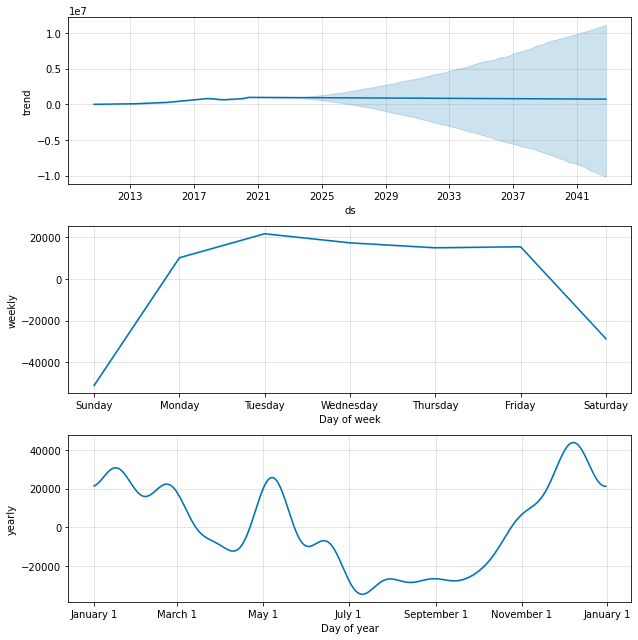

In [32]:
fig2 = m.plot_components(forecast)

In [33]:
df_train = df[['date', 'address']]
df_train = df_train.rename(columns = {"date":"ds", "address":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:43 - cmdstanpy - INFO - Chain [1] done processing
21:38:44 - cmdstanpy - INFO - Chain [1] start processing
21:38:46 - cmdstanpy - INFO - Chain [1] done processing


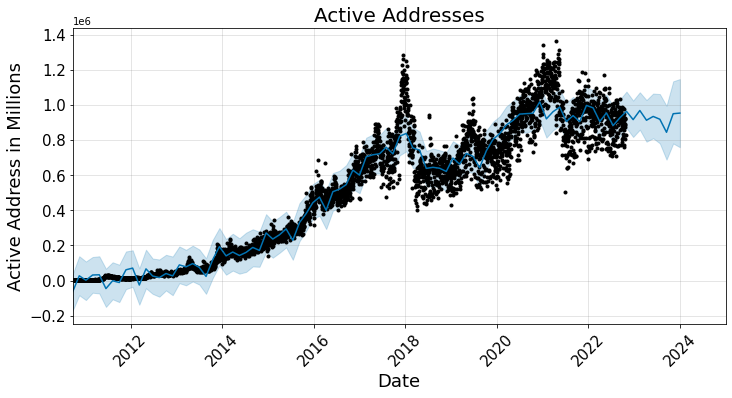

In [34]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-09-25", "2024-01-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("Active Addresses", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Active Address in Millions", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-09-25', '2024-12-31'])) 
plt.show();
# plt.savefig("../static/active_addressess.png")

In [35]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(name="Actual", x=df_train['ds'], y=df_train['y'], legendrank=4))
fig.add_trace(go.Scatter(name="Middle Bound Prediction", x=prediction['ds'], y=prediction['yhat'], legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound Prediction", x=prediction['ds'], y=prediction['yhat_lower'], legendrank=1))
fig.add_trace(go.Scatter(name="Upper Bound Prediction", x=prediction['ds'], y=prediction['yhat_upper'], legendrank=1))

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
fig.update_layout(title_text='Active Addressess and Date Prediction')
fig.update_yaxes(ticklabelposition="inside top", title="Active Addresses")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=20)

fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.show()
fig.write_html('../static/active_addressess.html')

In [36]:
df['ratio'] = df['wallets']/df['address']
print(df['ratio'].mean())

30.592055974813903


In [37]:
X = df.ratio
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=6.468532, mean2=54.715580
variance1=35.589105, variance2=637.139327


In [38]:
df.tail(15)

,date,price,wallets,address,mined,Metcafe,value,networkvalue,ratio
4371,2022-10-11,19059.1,84784364,897378.0,19176556.25,8.052873e+11,41993.32,-22934.22,94.480101
4372,2022-10-12,19154.8,84794965,872622.0,19177387.50,7.614692e+11,39706.62,-20551.82,97.172619
4373,2022-10-13,19379.8,84815738,946166.0,19178387.50,8.952301e+11,46679.11,-27299.31,89.641498
4374,2022-10-14,19181.8,84821900,980300.0,19179312.50,9.609881e+11,50105.45,-30923.65,86.526471
4375,2022-10-15,19068.7,84830177,858101.0,19180287.50,7.363373e+11,38390.32,-19321.62,98.858033
4376,2022-10-16,19261.9,84835804,762511.0,19181225.00,5.814230e+11,30312.09,-11050.19,111.258466
4377,2022-10-17,19548.2,84848488,872683.0,19182150.00,7.615756e+11,39702.31,-20154.11,97.227158
4378,2022-10-18,19328.2,84855520,884255.0,19182906.25,7.819069e+11,40760.61,-21432.41,95.962726
4379,2022-10-19,19123.9,84865792,922347.0,19183818.75,8.507240e+11,44345.91,-25222.01,92.010699
4380,2022-10-20,19042.9,84873410,889523.0,19184781.25,7.912512e+11,41243.69,-22200.79,95.414520


In [39]:
df.loc[df['ratio'] >= 80, 'ratio'].mean()

92.29606872745735